# A Million News Headlines

Le jeu de données est disponible à l'adresse suivante : https://www.kaggle.com/therohk/million-headlines
Il comporte des titres de journaux publiés sur le site ABC sur 15 années.

J'ai réalisé une analyse des titres de journaux en réfléchissant à des cas business d'application.

## Configuration

Utilisation de bibliothèques Python 3

In [1]:
! pip install gensim nltk wordcloud twython

The directory '/home/dorian/.cache/pip/http' or its parent directory is not owned by the current user and the cache has been disabled. Please check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
The directory '/home/dorian/.cache/pip' or its parent directory is not owned by the current user and caching wheels has been disabled. check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.


In [2]:
import pandas as pd
import numpy as np
from collections import defaultdict, Counter

import matplotlib.pyplot as plt
from wordcloud import WordCloud

import nltk
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("maxent_ne_chunker")
nltk.download("words")
nltk.download("vader_lexicon")
nltk.download("subjectivity")

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet, subjectivity

from nltk.classify import NaiveBayesClassifier
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import gensim
from gensim import corpora, models, similarities
from gensim.utils import ClippedCorpus, SlicedCorpus

[nltk_data] Downloading package stopwords to /home/dorian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/dorian/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /home/dorian/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /home/dorian/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/dorian/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package subjectivity to
[nltk_data]     /home/dorian/nltk_data...
[nltk_data]   Package subjectivity is already up-to-date!


## Chargement et transformation des données

##### Chargement des données

In [3]:
df = pd.read_csv("abcnews-date-text.csv", parse_dates=[0])

In [4]:
df.dtypes

publish_date     datetime64[ns]
headline_text            object
dtype: object

In [5]:
df.shape

(1103665, 2)

In [6]:
df.head(10)

,publish_date,headline_text
0,2003-02-19,aba decides against community broadcasting lic...
1,2003-02-19,act fire witnesses must be aware of defamation
2,2003-02-19,a g calls for infrastructure protection summit
3,2003-02-19,air nz staff in aust strike for pay rise
4,2003-02-19,air nz strike to affect australian travellers
5,2003-02-19,ambitious olsson wins triple jump
6,2003-02-19,antic delighted with record breaking barca
7,2003-02-19,aussie qualifier stosur wastes four memphis match
8,2003-02-19,aust addresses un security council over iraq
9,2003-02-19,australia is locked into war timetable opp


##### Tirage aléatoire de 80 000 titres

In [7]:
df = df.sample(80000).reset_index(drop=True)

In [8]:
df.head(10)

,publish_date,headline_text
0,2012-10-23,kangaroos deliberately rundown in conservation...
1,2005-09-03,bush under fire for hurricane response
2,2004-12-20,oil rig workers protest roster changes
3,2010-10-02,venus withdraws from china open
4,2009-06-21,nrl interview matthew cross
5,2017-10-17,the perils of travelling with a disability
6,2006-11-12,nz conservationists confident whales safe after
7,2010-06-22,new penalties for getting trucks stuck in tunnels
8,2009-08-18,smith regrets chinas diplomat decision
9,2014-11-04,lost in the private space race


##### Ajout de variables temporelles

In [9]:
df["day"] = df["publish_date"].dt.day
df["weekday"] = df["publish_date"].dt.weekday_name
df["week"] = df["publish_date"].dt.week
df["month"] = df["publish_date"].dt.month
df["year"] = df["publish_date"].dt.year

##### Tokenization et suppression des stopwords

In [10]:
df["headline_lower"] = df["headline_text"].str.lower()
df["headline_tokens"] = df["headline_lower"].str.split()
titles = df["headline_tokens"].values

In [11]:
%%time
stopWords = set(stopwords.words('english'))
titles_token = [[token for token in title if token not in stopWords] for title in titles]

CPU times: user 140 ms, sys: 0 ns, total: 140 ms
Wall time: 138 ms


##### Part-Of-Speech Tagging

In [12]:
%%time
titles_postag = [nltk.pos_tag(title_token) for title_token in titles_token]

CPU times: user 42.2 s, sys: 384 ms, total: 42.6 s
Wall time: 42.6 s


##### Lemmatisation

In [13]:
def get_wordnet_pos(treebank_tag):
    """
    Convertir le tag treebank au format wordnet
    """
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [14]:
%%time
lmtzr = WordNetLemmatizer()
titles_token_lem = [[lmtzr.lemmatize(token, pos=get_wordnet_pos(titles_postag[i][j][1]))
           for j, token in enumerate(title_token)] for i, title_token in enumerate(titles_token)]

CPU times: user 6.74 s, sys: 48 ms, total: 6.79 s
Wall time: 7.05 s


##### Suppression des mots
- apparaissant une seule fois
- d'un seul caractère

In [15]:
frequency = defaultdict(int)
for title in titles_token_lem:
    for token in title:
        frequency[token] += 1

titles_token_lem_filtered = [[token for token in title
                              if frequency[token] > 1 and len(token) > 1]
                             for title in titles_token_lem]

In [16]:
np.save("titles", titles_token_lem_filtered)

In [17]:
titles_token_lem_filtered = np.load("titles.npy")

##### Création d'un dictionnaire de mots

In [18]:
dictionary = corpora.Dictionary(titles_token_lem_filtered)
dictionary.save('newsheadlines.dict')
print(dictionary)

Dictionary(15699 unique tokens: ['area', 'conservation', 'deliberately', 'kangaroo', 'bush']...)


##### Transformation des titres en vecteur dit de "sac de mots"

In [19]:
titles_bow = [dictionary.doc2bow(title) for title in titles_token_lem_filtered]
corpora.MmCorpus.serialize('news-corpus.mm', titles_bow)

In [20]:
dictionary = corpora.Dictionary.load('newsheadlines.dict')
titles_bow = corpora.MmCorpus('news-corpus.mm')
print(titles_bow)

MmCorpus(80000 documents, 15699 features, 408020 non-zero entries)


##### Transformation des titres en vecteur tf-idf

In [21]:
tfidf = models.TfidfModel(titles_bow)
titles_tfidf = tfidf[titles_bow]

##### Echantillonnage

Les échantillons utilisés pour l'entraînement des modèles comportent 50 000 titres (tirés aléatoirement précédemment)

In [23]:
n_train = 50000
titles_bow_train = ClippedCorpus(titles_bow, n_train)
titles_tfidf_train = ClippedCorpus(titles_tfidf, n_train)

Les échantillons utilisés pour des analyses descriptives ou a des fins de mesure de performance comportent 80 000 titres (tirés aléatoirement précédemment)

In [24]:
n_test = 80000
titles_token_test = ClippedCorpus(titles_token_lem_filtered, n_test)
titles_bow_test = ClippedCorpus(titles_bow, n_test)
titles_tfidf_test = ClippedCorpus(titles_tfidf, n_test)

## Analyse de l'information contenue dans les titres

Pour appréhender l'information contenue dans les titres, j'ai choisi de:
    - représenter les expressions courantes en nuages de mots
    - extraire les entités nommées

#### Expressions courantes

In [25]:
%%time
text = ""
for title in titles_token_test:
    text = text + " " + " ".join(title)

CPU times: user 12.8 s, sys: 4 ms, total: 12.8 s
Wall time: 12.8 s


In [26]:
wordcloud = WordCloud(max_font_size=40).generate(text)

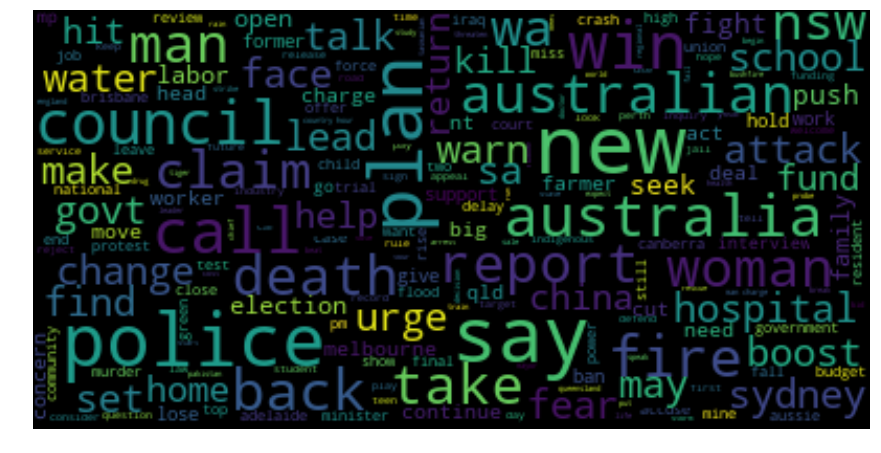

In [27]:
plt.close('all')
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Réconnaissance des entités nommées

La reconnaissance des entités nommées est une étape importante à la détection de relations. Malheureusement, le texte dont on dispose ne comporte que des caractères en minuscule. Cela empêche les algorithmes de reconnaissance d'entités nommées de fonctionner.

## Catégorisation des titres d'article par thème

Les titres d'articles de même thème pourront être:
    - proposés en recommandation de lecture
    - comparés selon l'opinion qu'ils expriment

In [28]:
def print_topics(model, n_topics, n_words):
    """
    Afficher les mots affectés pour chaque thème
    """
    topics = model.show_topics(num_topics=n_topics, num_words=n_words, log=False, formatted=False)
    for topic in topics:
        print("Thème %d: " %(topic[0]), *[word[0] for word in topic[1][:n_words]])

In [29]:
def get_top_topics(topic_probs, prob_limit=0.1):
    """
    Obtenir les thèmes avec une probabilité importante
    """
    return list(filter(lambda item: item[1] > prob_limit, topic_probs))

In [30]:
def get_first_topic(topic_probs):
    """
    Obtenir le premier thème d'un titre
    """
    return max(topic_probs, key=lambda item: item[1])[0]

In [31]:
def get_topic_words(model, title, n_words):
    """
    Obtenir les mots affectés à un thème
    """
    topics = model.show_topics(num_topics=-1, num_words=n_words, log=False, formatted=False)
    if len(model[title]) > 0:
        topic = get_first_topic(model[title])
        return " ".join(["Thème %d:" %(topics[topic][0])] + [word[0] for word in topics[topic][1][:n_words]])
    else:
        return "Aucun"

### Comparaison des modèles LSI et LDA

J'ai décidé de comparer deux modèles de classification de titres par thème. Pour ce faire, j'ai utilisé un nombre fixe de 100 thèmes.

In [32]:
n_topics = 100

#### Latent Semantic Analysis (LSI)

In [33]:
%%time
lsi = models.LsiModel(titles_tfidf_train, id2word=dictionary, num_topics=n_topics)

CPU times: user 14.7 s, sys: 312 ms, total: 15 s
Wall time: 6.8 s


In [34]:
print_topics(lsi, n_topics=5, n_words=4)

Thème 0:  man police charge court
Thème 1:  man charge plan new
Thème 2:  police man charge court
Thème 3:  interview extend michael john
Thème 4:  abc news business market


In [35]:
lsi.save("lsi-topics")

In [36]:
lsi = models.LsiModel.load("lsi-topics")

#### Latent Dirichlet Allocation (LDA)

In [37]:
%%time
lda = models.LdaModel(titles_bow_train, id2word=dictionary, num_topics=n_topics)

/opt/miniconda3/lib/python3.6/site-packages/gensim-3.3.0-py3.6-linux-x86_64.egg/gensim/models/ldamodel.py:802: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


CPU times: user 2min 1s, sys: 0 ns, total: 2min 1s
Wall time: 2min 1s


In [38]:
print_topics(lda, n_topics=5, n_words=4)

Thème 66:  say fear job target
Thème 5:  brisbane bid well officer
Thème 28:  defend party question men
Thème 11:  study tiger considers last
Thème 21:  murder tell trial rock


In [39]:
lda.save("lda-topics")

In [40]:
lda = models.LdaModel.load("lda-topics")

#### Exemple de premiers thèmes extraits

Les modèles utilisés permettent d'obtenir une liste réduite de thèmes pour chaque titre. Le "premier thème" d'un titre correspond au thème avec la probabilité d'appartenance la plus forte.

In [41]:
for idx, title in enumerate(titles_tfidf[:5]):
    
    print("Title:", df.loc[idx, "headline_text"])
    print("Title transformed: ", titles_token_lem_filtered[idx])
    print("LDA topic =>", get_topic_words(lda, titles_bow[idx], n_words=4))
    print("LSI topic =>", get_topic_words(lsi, title, n_words=4))
    print()

Title: kangaroos deliberately rundown in conservation area
Title transformed:  ['kangaroo', 'deliberately', 'conservation', 'area']
LDA topic => Thème 72: court drug rule cause
LSI topic => Thème 77: flood china talk mp

Title: bush under fire for hurricane response
Title transformed:  ['bush', 'fire', 'hurricane', 'response']
LDA topic => Thème 62: accuse guilty chinese hand
LSI topic => Thème 6: new fire call govt

Title: oil rig workers protest roster changes
Title transformed:  ['oil', 'rig', 'worker', 'protest', 'roster', 'change']
LDA topic => Thème 51: rise rate low gay
LSI topic => Thème 27: change rise get report

Title: venus withdraws from china open
Title transformed:  ['venus', 'withdraws', 'china', 'open']
LDA topic => Thème 14: farmer blaze pledge tasmania
LSI topic => Thème 71: set accuse fear boost

Title: nrl interview matthew cross
Title transformed:  ['nrl', 'interview', 'matthew', 'cross']
LDA topic => Thème 33: end return aid extend
LSI topic => Thème 90: work ret

#### Nombre de thèmes par titre

In [42]:
%%time
number_lsi_topics = [len(title_lsi) for title_lsi in lsi[titles_tfidf_test]]
number_lda_topics = [len(title_lda) for title_lda in lda[titles_bow_test]]

CPU times: user 2min 44s, sys: 8 ms, total: 2min 44s
Wall time: 2min 44s


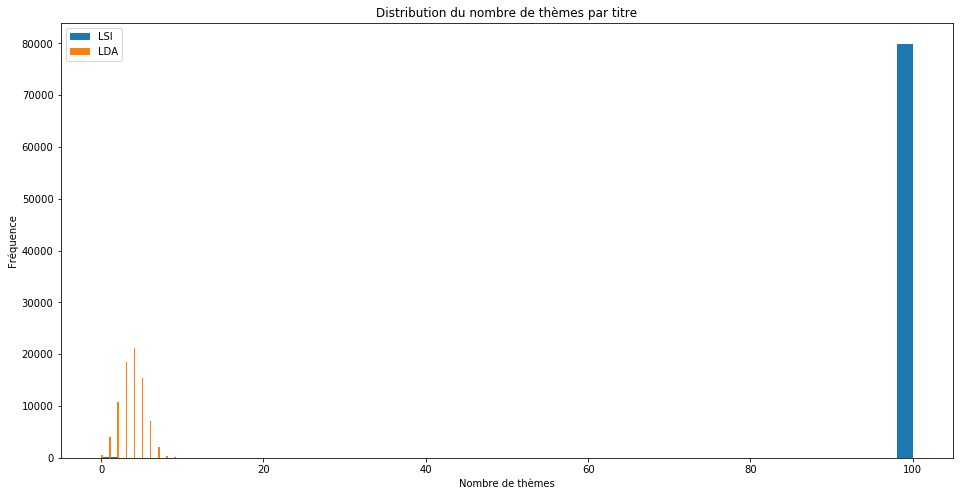

In [43]:
plt.close('all')
fig, axes = plt.subplots(figsize=(16,8))

plt.hist(number_lsi_topics, bins=50, label="LSI")
plt.hist(number_lda_topics, bins=50, label="LDA")

plt.xlabel("Nombre de thèmes")
plt.ylabel("Fréquence")
plt.legend(loc='best')
plt.title('Distribution du nombre de thèmes par titre')
plt.show()

On remarque ci-dessus que le modèle LSI prédit des probabilités non nulles pour chaque thème. Pour comparer la répartition du nombre de thèmes par titre, j'ai décidé de ne conserver que les thèmes avec une probabilité d'appartenance supérieure à 1/10. Ci-dessous le traitement réalisé:

In [44]:
%%time
number_lsi_top_topics = [len(get_top_topics(title_lsi, prob_limit=0.1)) for title_lsi in lsi[titles_tfidf_test]]
number_lda_top_topics = [len(get_top_topics(title_lda, prob_limit=0.1)) for title_lda in lda[titles_bow_test]]

CPU times: user 2min 45s, sys: 60 ms, total: 2min 46s
Wall time: 2min 46s


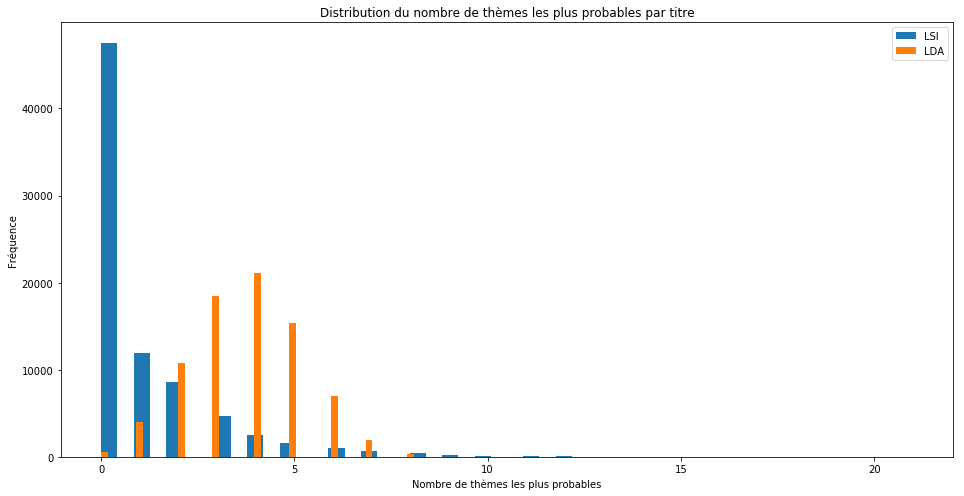

In [45]:
plt.close('all')
fig, axes = plt.subplots(figsize=(16,8))

plt.hist(number_lsi_top_topics, bins=50, label="LSI")
plt.hist(number_lda_top_topics, bins=50, label="LDA")

plt.xlabel("Nombre de thèmes les plus probables")
plt.ylabel("Fréquence")
plt.legend(loc='best')
plt.title('Distribution du nombre de thèmes les plus probables par titre')
plt.show()

Le graphique ci-dessus montre que le modèle LSI ne permet pas d'obtenir un thème pour la moitié des titres. Pour le modèle LDA, la distribution paraît plus adaptée à ce que l'on souhaite obtenir. Il y a peu de titres pour lesquels on n'obtient pas de thème avec une probabilité supérieure à 1/10.

#### Répartition des premiers thèmes

In [46]:
%%time 
lsi_first_topic = [get_first_topic(title_lsi) for title_lsi in lsi[titles_tfidf_test] if len(title_lsi) > 0]

CPU times: user 9.56 s, sys: 20 ms, total: 9.58 s
Wall time: 9.83 s


In [47]:
%%time 
lda_first_topic = [get_first_topic(title_lda) for title_lda in lda[titles_bow_test] if len(title_lda) > 0]

CPU times: user 2min 33s, sys: 100 ms, total: 2min 33s
Wall time: 2min 34s


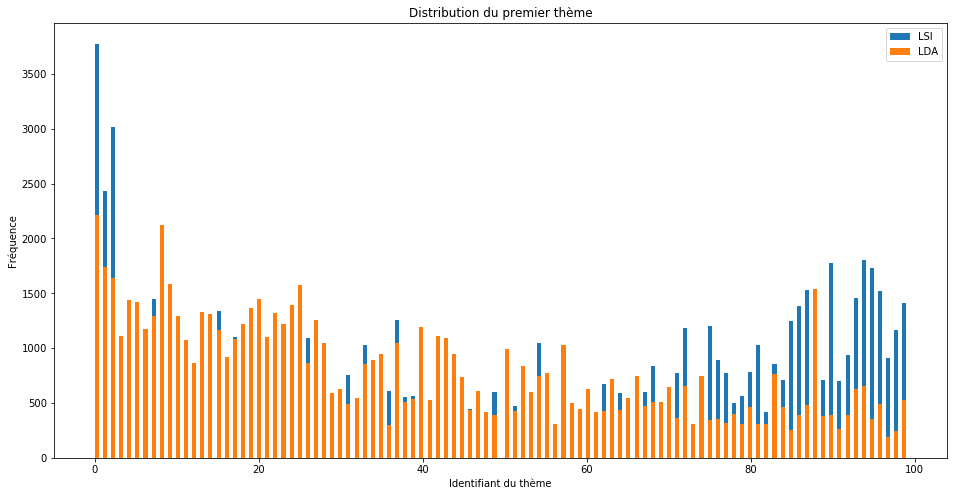

In [48]:
plt.close('all')
fig, axes = plt.subplots(figsize=(16,8))

plt.hist(lsi_first_topic, bins=200, label="LSI")
plt.hist(lda_first_topic, bins=200, label="LDA")

plt.xlabel("Identifiant du thème")
plt.ylabel("Fréquence")
plt.legend(loc='best')
plt.title('Distribution du premier thème')
plt.show()

La répartition des titres par thème semble plus adaptée pour le modèle LDA que pour le modèle LSI. En effet, pour le modèle LSI, beaucoup de thèmes n'ont aucun titre et quelques uns en ont beaucoup plus que les autres.

## Analyse de sentiments

### Polarité

- Proposer des articles avec une opinion similaire ou contradictoire portant sur une même thématique
- Suivre l'évolution des opinions des articles au cours du temps

#### Valence Aware Dictionary for sEntiment Reasoning (VADER)

In [49]:
%%time
sid = SentimentIntensityAnalyzer()
df.loc[test_indexes, "polarity_score"] = [sid.polarity_scores(" ".join(title_token))["compound"] 
                                          for title_token in titles_token_test]

df.loc[df["polarity_score"] > 0, "polarity"] = "pos"
df.loc[df["polarity_score"] == 0, "polarity"] = "neu"
df.loc[df["polarity_score"] < 0, "polarity"] = "neg"

CPU times: user 9.23 s, sys: 16 ms, total: 9.24 s
Wall time: 9.25 s


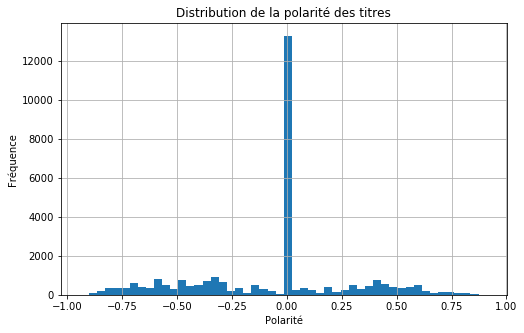

In [50]:
plt.close('all')
fig, axes = plt.subplots(figsize=(8,5))

df.loc[test_indexes, "polarity_score"].hist(bins=50)

plt.xlabel("Polarité")
plt.ylabel("Fréquence")
plt.title('Distribution de la polarité des titres')
plt.show()

On peut voir sur le graphe ci-dessus que plus d'un tier des articles expriment une opinion neutre. Les deux petits tiers restant semblent être équitablement répartis entre des opinions positives ou négatives.

In [51]:
polarity_score_by_week_and_year = df.loc[test_indexes].groupby(["year", "week"])["polarity_score"].mean()
polarity_score_by_month_and_year = df.loc[test_indexes].groupby(["year", "month"])["polarity_score"].mean()
polarity_score_by_year = df.loc[test_indexes].groupby(["year"])["polarity_score"].mean()

In [52]:
std_polarity_score_by_week_and_year = df.loc[test_indexes].groupby(["year", "week"])["polarity_score"].std()
std_polarity_score_by_month_and_year = df.loc[test_indexes].groupby(["year", "month"])["polarity_score"].std()
std_polarity_score_by_year = df.loc[test_indexes].groupby(["year"])["polarity_score"].std()

In [53]:
polarity_by_year = df.loc[test_indexes].groupby(["year", "polarity"])["polarity"].count().unstack()

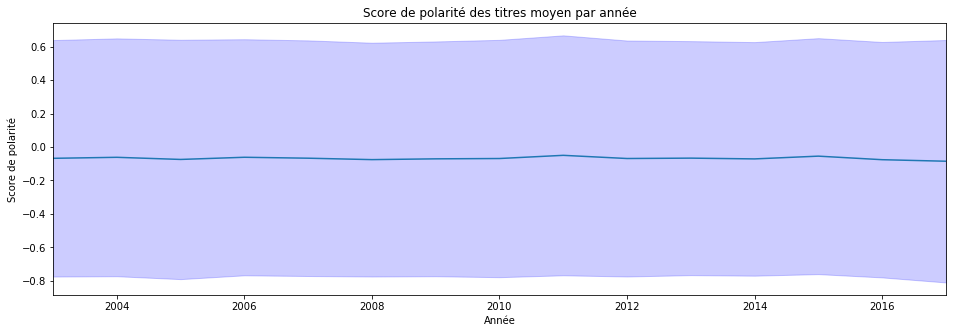

In [54]:
plt.close('all')
fig, ax = plt.subplots(figsize=(16,5))

polarity_score_by_year.plot()
plt.fill_between(std_polarity_score_by_year.index, polarity_score_by_year-2*std_polarity_score_by_year,
                 polarity_score_by_year+2*std_polarity_score_by_year, color='b', alpha=0.2)

plt.xlabel("Année")
plt.ylabel("Score de polarité")
plt.title('Score de polarité des titres moyen par année')
plt.show()

Le graphique ci-dessous permet de qualifier la tendance suivi par l'opinion exprimée dans les titres d'articles parus chaque année. Cette tendance est plutôt stable et neutre.

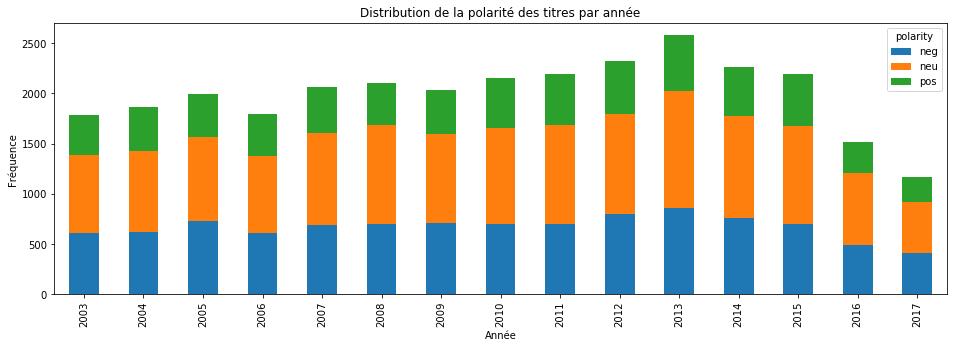

In [55]:
plt.close('all')
fig, ax = plt.subplots(figsize=(16,5))

polarity_by_year.plot.bar(stacked=True, ax=ax)

plt.xlabel("Année")
plt.ylabel("Fréquence")
plt.title('Distribution de la polarité des titres par année')
plt.show()

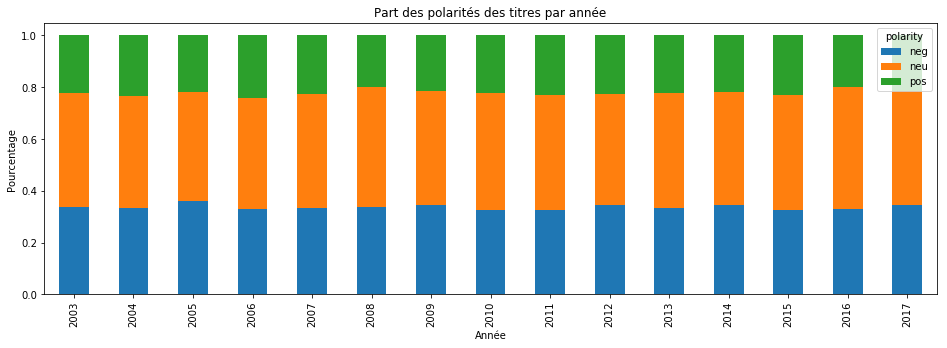

In [56]:
plt.close('all')
fig, ax = plt.subplots(figsize=(16, 5))

df.groupby(['year', 'polarity'])["polarity"].count().unstack().div(
    df.groupby(['year', 'polarity'])["polarity"].count().unstack().sum(axis=1),
    axis=0).plot.bar(ax=ax, stacked=True)

plt.xlabel("Année")
plt.ylabel("Pourcentage")
plt.title('Part des polarités des titres par année')
plt.show()

Les deux derniers graphiques montrent une stabilité de la part des opinions négatives, neutres et positives exprimées dans les titres chaque année. La volumétrie des titres dans l'échantillon diminue fortement entre 2016 et 2017 après avoir augmenté puis stagné les années précédentes.

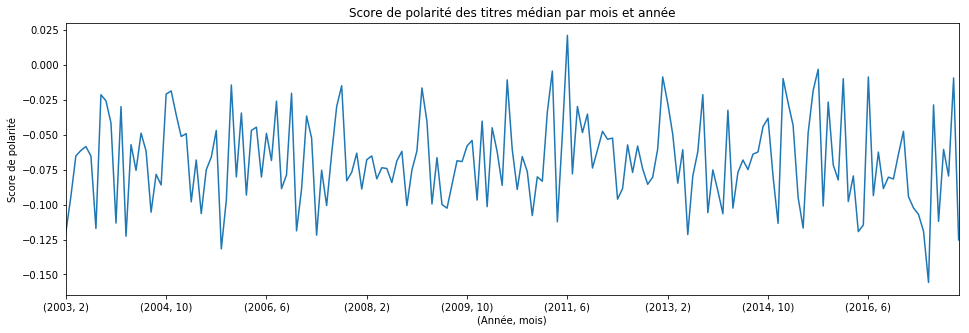

In [57]:
plt.close('all')
fig, ax = plt.subplots(figsize=(16,5))

polarity_score_by_month_and_year.plot()

plt.xlabel("(Année, mois)")
plt.ylabel("Score de polarité")
plt.title('Score de polarité des titres médian par mois et année')
plt.show()

La variation du score de polarité moyen par mois peut être important comme on le voit illustré sur le graphique ci-dessus.

Cette variabilité est d'autant plus forte en choisissant une périodicité hebdomadaire. On peut émettre l'hypothèse que cette polarité est fortement influencée par la nature des sujets qui font l'actualité.

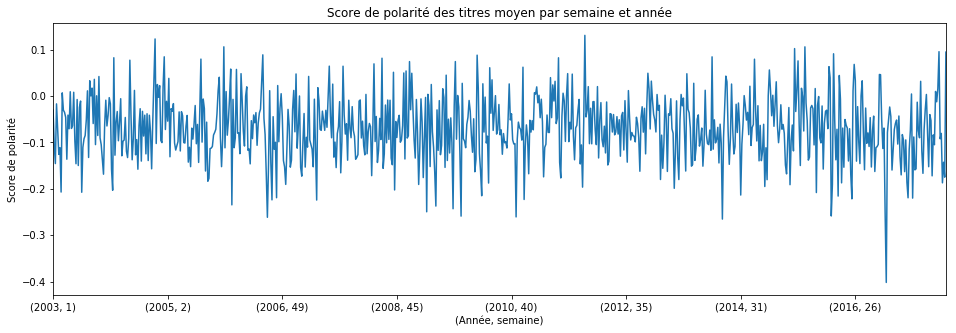

In [58]:
plt.close('all')
fig, ax = plt.subplots(figsize=(16,5))

polarity_score_by_week_and_year.plot()


plt.xlabel("(Année, semaine)")
plt.ylabel("Score de polarité")
plt.title('Score de polarité des titres moyen par semaine et année')
plt.show()

In [59]:
months = ['January', 'Februrary', 'March', 'April', 'May', 'June', 'July', 'August', 'September',
           'October', 'November', 'December']
polarity_score_by_month = [df.iloc[test_indexes][df.loc[test_indexes, "month"] == month_number + 1]["polarity_score"].values
                       for month_number, month in enumerate(months)]

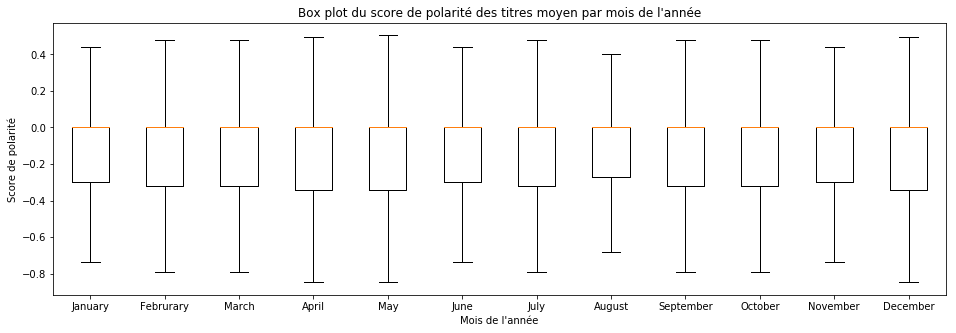

In [60]:
plt.close('all')
fig, ax = plt.subplots(figsize=(16, 5))

plt.boxplot(polarity_score_by_month, 0, '')

plt.xticks(range(1, len(months) + 1), months)
plt.xlabel("Mois de l'année")
plt.ylabel("Score de polarité")
plt.title("Box plot du score de polarité des titres moyen par mois de l'année")
plt.show()

Il pouvait être intéressant d'observer un éventuelle phénomène de saisonnalité sur une périodicité mensuelle ou hébdomadaire. Le graphique précédent et suivant n'illustre pas de manière flagrante l'existence d'un phénomène de saisonnalité.

On pourra tout de même noter que le mois d'août présente des valeurs extrêmes de score de polarité moins élevées.

In [61]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
polarity_score_by_weekday = [df.iloc[test_indexes][df.loc[test_indexes, "weekday"] == day]["polarity_score"].values
                       for day in days]

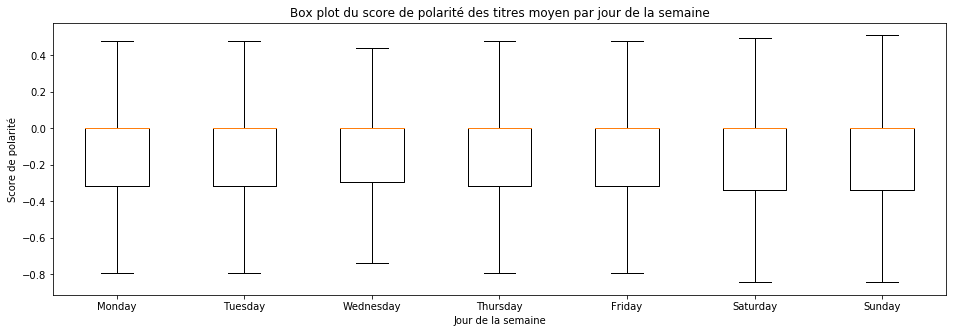

In [62]:
plt.close('all')
fig, ax = plt.subplots(figsize=(16, 5))

plt.boxplot(polarity_score_by_weekday, 0, '')

plt.xticks(range(1, len(days) + 1), days)
plt.xlabel("Jour de la semaine")
plt.ylabel("Score de polarité")
plt.title('Box plot du score de polarité des titres moyen par jour de la semaine')
plt.show()

### Subjectivité:

La subjectivité d'un titre est une métrique qui pourrait être révélatrice de la qualité journalistique d'un article. Ainsi on pourrait:

    - Proposer à un lecteur des articles plus objectifs portant sur une thématique qu'il apprécie
    - Suivre l'évolution de l'objectivité des titres pour corriger une ligne éditoriale

#### Entraînement d'un classifieur Bayésien Naïf à partir d'un jeu de phrases labellisées subjectives et objectives

In [63]:
n_instances = 5000 # Nombre de documents labellisés subjectif/objectif dans le jeu de données complet
subj_docs = [(sent, 'subj') for sent in subjectivity.sents(categories='subj')[:n_instances]]
obj_docs = [(sent, 'obj') for sent in subjectivity.sents(categories='obj')[:n_instances]]

In [64]:
train_subj_docs = subj_docs[:int(n_instances*0.8)]
test_subj_docs = subj_docs[int(n_instances*0.8):n_instances]
train_obj_docs = obj_docs[:int(n_instances*0.8)]
test_obj_docs = obj_docs[int(n_instances*0.8):n_instances]
training_docs = train_subj_docs+train_obj_docs
testing_docs = test_subj_docs+test_obj_docs

In [65]:
sentim_analyzer = SentimentAnalyzer()
all_words_neg = sentim_analyzer.all_words([mark_negation(doc) for doc in training_docs])

In [66]:
# We use simple unigram word features, handling negation:

unigram_feats = sentim_analyzer.unigram_word_feats(all_words_neg, min_freq=4)
sentim_analyzer.add_feat_extractor(extract_unigram_feats, unigrams=unigram_feats)

In [67]:
# We apply features to obtain a feature-value representation of our datasets:

training_set = sentim_analyzer.apply_features(training_docs)
test_set = sentim_analyzer.apply_features(testing_docs)

In [68]:
%%time

# We can now train our classifier on the training set, and subsequently output the evaluation results:

trainer = NaiveBayesClassifier.train
classifier = sentim_analyzer.train(trainer, training_set)

for key,value in sorted(sentim_analyzer.evaluate(test_set).items()):
    print('{0}: {1}'.format(key, value))

Training classifier
Evaluating NaiveBayesClassifier results...
Accuracy: 0.91
F-measure [obj]: 0.908256880733945
F-measure [subj]: 0.9116781157998036
Precision [obj]: 0.9261954261954262
Precision [subj]: 0.894990366088632
Recall [obj]: 0.891
Recall [subj]: 0.929
CPU times: user 3min 32s, sys: 280 ms, total: 3min 32s
Wall time: 3min 32s


#### Prédiction de la subjectivité des titres avec le classifieur entraîné

In [69]:
%%time
df.loc[test_indexes, "subjectivity"] = [sentim_analyzer.classify(title) for title in titles_token_test]

CPU times: user 29min 58s, sys: 116 ms, total: 29min 58s
Wall time: 29min 58s


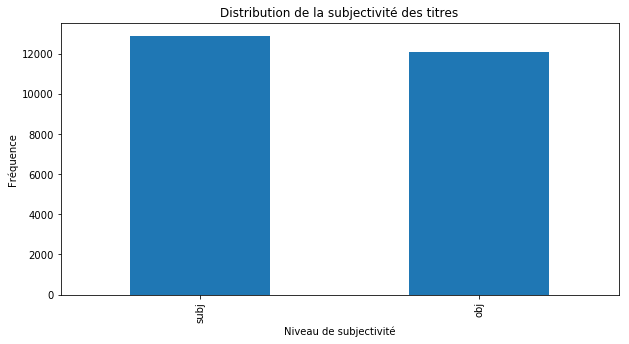

In [80]:
plt.close('all')
fig, axes = plt.subplots(figsize=(10, 5))

df.loc[df['subjectivity'] != "nan", 'subjectivity'].value_counts().plot(kind='bar')

plt.xlabel("Niveau de subjectivité")
plt.ylabel("Fréquence")
plt.title('Distribution de la subjectivité des titres')
plt.show()

Le graphe ci-dessus illustre une répartition des titres objectifs et subjectifs quasiment paritaire.

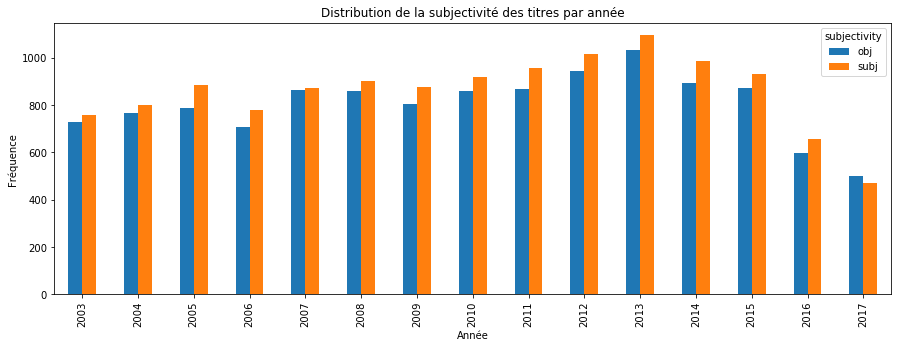

In [82]:
plt.close('all')
fig, ax = plt.subplots(figsize=(15, 5))

df.loc[df['subjectivity'] != "nan"].groupby(["year", 'subjectivity'])["subjectivity"].count().unstack().plot(kind='bar', ax=ax)

plt.xlabel("Année")
plt.ylabel("Fréquence")
plt.title('Distribution de la subjectivité des titres par année')
plt.show()

On observe sur le graphe ci-dessus un accroissement sensible du nombre de titres subjectifs et otjectifs entre 2010 et 2013. La part des titres objectifs et subjectif évolue légèrement suivant les années.

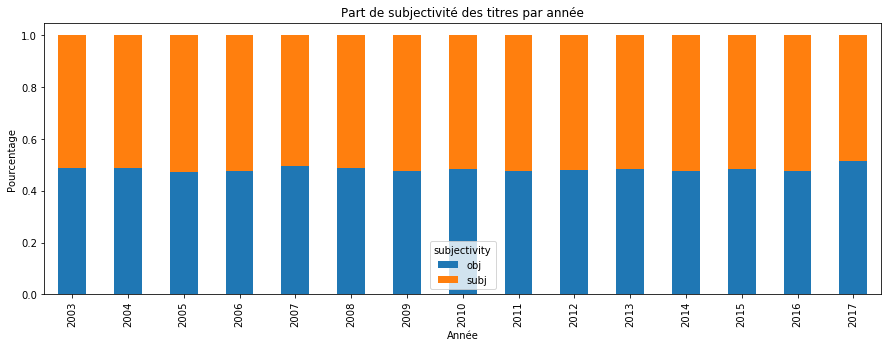

In [84]:
plt.close('all')
fig, ax = plt.subplots(figsize=(15, 5))

df.loc[df['subjectivity'] != "nan"].groupby(['year', 'subjectivity'])["subjectivity"].count().unstack().div(
    df.loc[df['subjectivity'] != "nan"].groupby(['year', 'subjectivity'])["subjectivity"].count().unstack().sum(axis=1),
    axis=0).plot.bar(ax=ax, stacked=True)

plt.xlabel("Année")
plt.ylabel("Pourcentage")
plt.title('Part de subjectivité des titres par année')
plt.show()

On constate une certaine stabilité de la part des titres objectifs et suibjectif au cours du temps. Il existe cependant des fluxtations qui sont difficilement quantifiables à l'observation du graphique.

Toute conclusion à ce stade est encore précipitée mais on pourrait mesurer la corrélation entre la subjectivité des titres et d'autres caractéristiques.

In [85]:
subjectivity_proportion_by_year = df.loc[df['subjectivity'] != "nan"].groupby(['year', 'subjectivity'])["subjectivity"].count().unstack().div(
                                    df.groupby(['year', 'subjectivity'])["subjectivity"].count().unstack().sum(axis=1),
                                    axis=0)

In [86]:
polarity_proportion_by_year = df.loc[df['subjectivity'] != "nan"].groupby(['year', 'polarity'])["polarity"].count().unstack().div(
    df.groupby(['year', 'polarity'])["polarity"].count().unstack().sum(axis=1),
    axis=0)

In [87]:
print("Corrélations (périodicité ANNUELLE de 2003-2017) entre la proportion des titres subjectifs et:")

print("- négatifs: %.2f" %(
    subjectivity_proportion_by_year["subj"].corr(polarity_proportion_by_year["neg"], method='pearson')))
print("- neutre: %.2f" %(
    subjectivity_proportion_by_year["subj"].corr(polarity_proportion_by_year["neu"], method='pearson')))
print("- positifs: %.2f" %(
    subjectivity_proportion_by_year["subj"].corr(polarity_proportion_by_year["pos"], method='pearson')))

Corrélations (périodicité ANNUELLE de 2003-2017) entre la proportion des titres subjectifs et:
- négatifs: -0.23
- neutre: 0.20
- positifs: -0.03


In [89]:
subjectivity_proportion_by_month_year = df.loc[df['subjectivity'] != "nan"].groupby(['year', 'month', 'subjectivity'])["subjectivity"].count().unstack().div(
                                    df.groupby(['year', 'month', 'subjectivity'])["subjectivity"].count().unstack().sum(axis=1),
                                    axis=0)

In [90]:
polarity_proportion_by_month_year = df.loc[df['subjectivity'] != "nan"].groupby(['year', 'month', 'polarity'])["polarity"].count().unstack().div(
    df.groupby(['year', 'month', 'polarity'])["polarity"].count().unstack().sum(axis=1),
    axis=0)

In [91]:
print("Corrélations (périodicité MENSUELLE de 2003-2017) entre la proportion des titres subjectifs et:")

print("- négatifs: %.2f" %(
    subjectivity_proportion_by_month_year["subj"].corr(polarity_proportion_by_month_year["neg"], method='pearson')))
print("- neutre: %.2f" %(
    subjectivity_proportion_by_month_year["subj"].corr(polarity_proportion_by_month_year["neu"], method='pearson')))
print("- positifs: %.2f" %(
    subjectivity_proportion_by_month_year["subj"].corr(polarity_proportion_by_month_year["pos"], method='pearson')))

Corrélations (périodicité MENSUELLE de 2003-2017) entre la proportion des titres subjectifs et:
- négatifs: -0.18
- neutre: 0.17
- positifs: -0.01


L'influence mutuelle entre la subjectivité et la polarité est faible sur la période étudiée entre 2003 et 2017.